In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.options.display.max_colwidth=200
# Source: http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
plt.style.use('seaborn-colorblind')

In [267]:
# Load Data
subreddits_combined_file = 'subreddits_combined.csv'
posts = pd.read_csv('../data/' + subreddits_combined_file)

In [268]:
# Preview Data
posts.head()

,title,score,id,url,comms_num,created,body,subreddit
0,"Before his death, John F. Kennedy's original name was John Kennedy. The ""F"" was later added to pay respects.",881,9hp7cr,https://www.reddit.com/r/FakeFacts/comments/9hp7cr/before_his_death_john_f_kennedys_original_name/,37,1.537561e+09,NaN,fakefacts
1,Jumping was created by Thomas Jump when he tried to stand twice,761,9va584,https://www.reddit.com/r/FakeFacts/comments/9va584/jumping_was_created_by_thomas_jump_when_he_tried/,57,1.541714e+09,NaN,fakefacts
2,"until 1939, H2O wasn't water. Water was originally created from the compound H3O, but it was discontinued because people thought it was too wet.",731,9uwj3y,https://www.reddit.com/r/FakeFacts/comments/9uwj3y/until_1939_h2o_wasnt_water_water_was_originally/,12,1.541597e+09,NaN,fakefacts
3,"If you changed the date on your iPhone to one in the future, you will actually get future IOS updates",653,9uficc,https://www.reddit.com/r/FakeFacts/comments/9uficc/if_you_changed_the_date_on_your_iphone_to_one_in/,9,1.541468e+09,NaN,fakefacts
4,A Female Peacock is Called a Peacunt,640,9vdks8,https://www.reddit.com/r/FakeFacts/comments/9vdks8/a_female_peacock_is_called_a_peacunt/,21,1.541737e+09,Edit: Thanks for the Silver!,fakefacts


In [269]:
# Data Types
posts.dtypes

title         object
score          int64
id            object
url           object
comms_num      int64
created      float64
body          object
subreddit     object
dtype: object

In [270]:
# Check for null values
posts.isnull().sum()

title           0
score           0
id              0
url             0
comms_num       0
created         0
body         1618
subreddit       0
dtype: int64

In [271]:
posts['subreddit'].value_counts()

science      990
fakefacts    981
Name: subreddit, dtype: int64

In [272]:
# Convert 'created' column to date 
posts['created'] = posts['created'].map(lambda cell: datetime.datetime.fromtimestamp(cell).strftime('%Y'))

### Exploratory Data Analysis and Feature Engineering

In [273]:
posts.describe()

,score,comms_num
count,1971.000000,1971.000000
mean,25441.427702,997.564181
std,27209.650674,1348.257140
min,1.000000,0.000000
25%,24.000000,2.000000
50%,36556.000000,454.000000
75%,46675.500000,1682.000000
max,199294.000000,11028.000000


In [274]:
# Check how many posts in each subreddit have body text
posts.groupby('subreddit')[['body']].count()

,body
subreddit,
fakefacts,347
science,6


In [275]:
posts.groupby('subreddit')[['comms_num','score']].mean()

,comms_num,score
subreddit,,
fakefacts,3.519878,62.375127
science,1982.571717,50589.761616


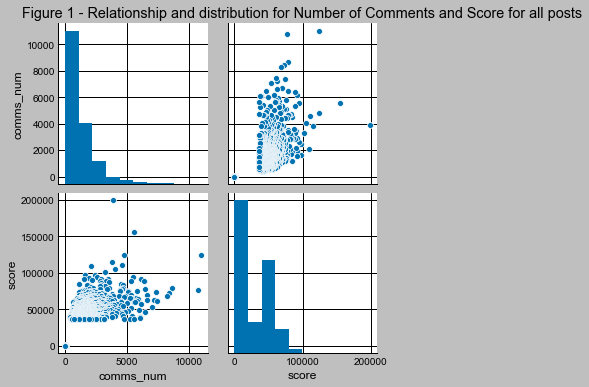

In [276]:
# Check the relationship and distribution for number of columns and score
sns.pairplot(posts[['comms_num','score']]);
plt.title('Figure 1 - Relationship and distribution for Number of Comments and Score for all posts');

Observations from scatterplots/histograms:

    The number of columns and score distributions are skewed narrow and skewed to the right
    Score looks slighlty positevely correlated with the number of comments
  

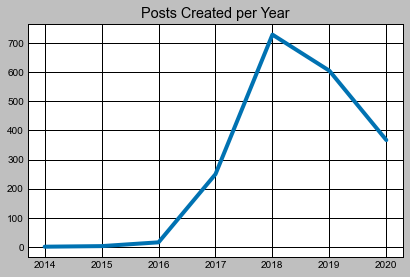

In [277]:
dates = posts['created'].value_counts()
dates = dates.reset_index().sort_values(by=['index'])
plt.plot(dates['index'], dates['created']);
plt.title('Posts Created per Year');

### EDA on Number of Words per post

Create a column for word_count for the number of words in the title

In [278]:
posts['word_count'] = posts['title'].map(lambda title: len(title.split()))

In [284]:
posts.groupby('subreddit')['word_count'].mean()

subreddit
fakefacts    19.475025
science      35.617172
Name: word_count, dtype: float64

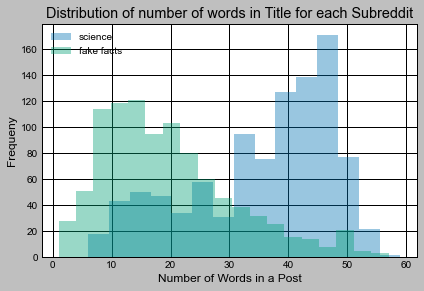

In [283]:
sns.distplot(posts[posts['subreddit'] == 'science']['word_count'], kde=False ,label ='science');
sns.distplot(posts[posts['subreddit'] == 'fakefacts']['word_count'], kde=False, label ='fake facts');
plt.legend();
plt.title('Distribution of number of words in Title for each Subreddit');
plt.xlabel('Number of Words in a Post');
plt.ylabel('Frequeny');

In [217]:
posts.sort_values(by=['word_count'])[['title','word_count','subreddit']][:5]

,title,word_count,subreddit
101,Igor,1,fakefacts
898,Fakefact,1,fakefacts
718,Wholesome,1,fakefacts
670,Cabbage,1,fakefacts
638,Banana fact!,2,fakefacts


In [218]:
posts.sort_values(by=['word_count'], ascending=False)[['title','word_count','subreddit']][:5]

,title,word_count,subreddit
1958,"In survey of people who maintained 30 lbs of weight loss in a year, 68% worked out at the same time each day, 47.8% of whom worked out in the early morning. Timing was key to forming an exercise h...",59,science
979,"French fries where invented when in 1876 a potato farmer was harvesting his crops, he accidentally cut one of his potatoes, he saw the cut potato and decided it could be his food. he cut a few of ...",57,fakefacts
931,If your leg hurts below the knee you may go behind the knee and hold the blood vessel closed. This will stop blood flow to the leg causing the nerves to slow down to save oxygen in the blood. Once...,57,fakefacts
1554,Weekend sleep-ins may counteract the effects of lack of sleep during weekdays - Adults under the age of 65 who get 5 or fewer hours of sleep may have a higher risk of death compared to those who g...,56,science
1545,"A new study of suicide timing in 18 US states found that suicide rates rose in March, peaked in September, and was lowest in December. Suicide was more likely to occur in the first week of the mon...",55,science




### EDA on Title Text

Use Count Vectorizer

Pre-Processing Unstructured Text

- Remove special characters
- Tokenizing
- Lemmatizing/Stemming
- Stop word removal

In [348]:
# cvec = CountVectorizer()
# Run CountVectorizer() without passing any stop words. Reviewed the most common words and there were mostly
# pronouns. Decided to re run using stop_words = 'english' 
cvec = CountVectorizer(stop_words='english', max_features = 1000, ngram_range=(1,2))
cvec.fit(posts['title'])
title_cvec = cvec.transform(posts['title'])
title_df = pd.DataFrame(title_cvec.todense(), columns=cvec.get_feature_names())

In [349]:
title_df.sum().sort_values(ascending=False)[:10]

new           441
study         419
new study     222
people        208
suggests      143
actually      130
finds         122
scientists    108
years         106
research      103
dtype: int64

In [350]:
cvec_trigram = CountVectorizer(stop_words='english', ngram_range=(3,3))
cvec_trigram.fit(posts['title'])
title_cvec_trigram = cvec_trigram.transform(posts['title'])
title_df_trigram = pd.DataFrame(title_cvec_trigram.todense(), columns=cvec_trigram.get_feature_names())

In [351]:
title_df_trigram.sum().sort_values(ascending=False)[:10]

suggests new study         72
finds new study            35
according new study        23
according new research     17
new study shows            12
contrary popular belief    12
new study finds            11
new study suggests          9
finds new research          9
suggests new research       8
dtype: int64

Most common words based on subreddit

In [352]:
subreddit_name = posts[['subreddit']]

In [354]:
subreddit_name.columns=['subreddit_name']

In [356]:
text_and_subreddit = pd.concat([subreddit_name, title_df], axis=1)

In [357]:
text_and_subreddit.head()

,subreddit_name,000,000 years,10,100,11,12,13,14,15,...,worse,worth,writing,year,year old,years,years ago,york,young,young adults
0,fakefacts,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fakefacts,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,fakefacts,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,fakefacts,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,fakefacts,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


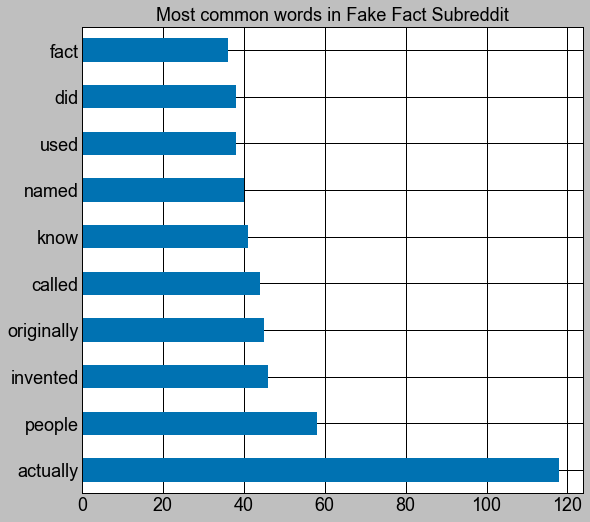

In [368]:
plt.figure(figsize=[8,8])
plt.title('Most common words in Fake Fact Subreddit', fontsize=18)
fakefacts_words = text_and_subreddit[text_and_subreddit['subreddit_name']=='fakefacts'][cvec.get_feature_names()].sum()
fakefacts_words.sort_values(ascending=False)[:10].plot.barh();
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

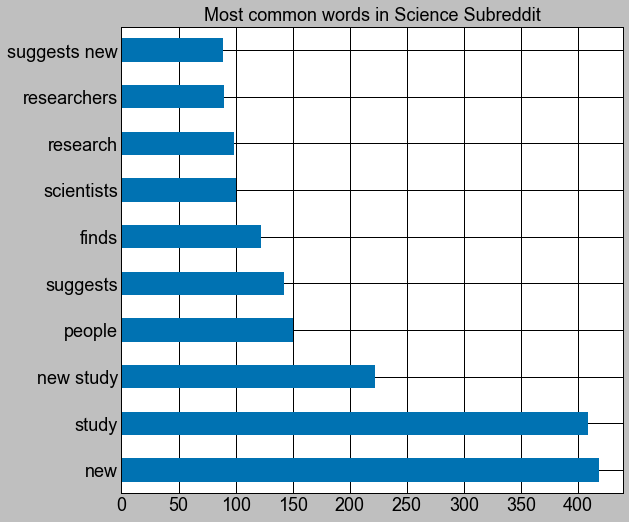

In [369]:
plt.figure(figsize=[8,8])
plt.title('Most common words in Science Subreddit', fontsize=18)
science_words = text_and_subreddit[text_and_subreddit['subreddit_name'] == 'science'][cvec.get_feature_names()].sum()
science_words.sort_values(ascending=False)[:10].plot.barh();
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

Vectorize using Term frequency-inverse document frequency

In [394]:
tf_vec = TfidfVectorizer(stop_words='english', max_features = 1000, ngram_range=(2,2))
tf_vec.fit(posts['title'])
title_tfvec = tf_vec.transform(posts['title'])
title_tf_df = pd.DataFrame(title_tfvec.todense(), columns=tf_vec.get_feature_names())

In [395]:
tf_text_and_subreddit = pd.concat([subreddit_name, title_tf_df], axis=1)

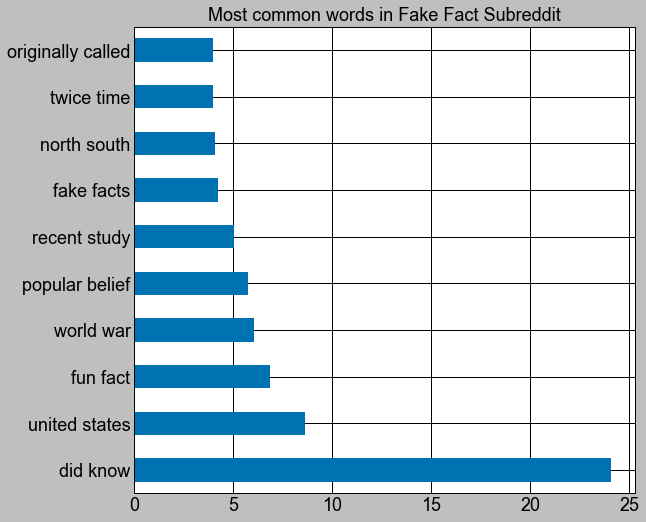

In [396]:
plt.figure(figsize=[8,8])
plt.title('Most common words in Fake Fact Subreddit', fontsize=18)
fakefacts_words = tf_text_and_subreddit[tf_text_and_subreddit['subreddit_name']=='fakefacts'][tf_vec.get_feature_names()].sum()
fakefacts_words.sort_values(ascending=False)[:10].plot.barh();
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

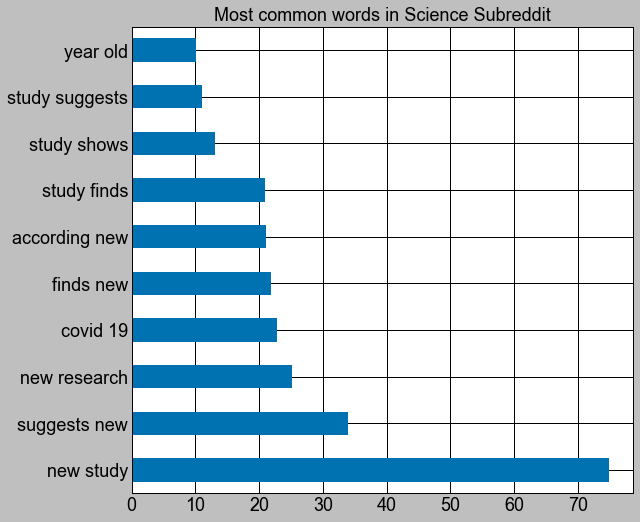

In [397]:
plt.figure(figsize=[8,8])
plt.title('Most common words in Science Subreddit', fontsize=18)
science_words = tf_text_and_subreddit[tf_text_and_subreddit['subreddit_name'] == 'science'][tf_vec.get_feature_names()].sum()
science_words.sort_values(ascending=False)[:10].plot.barh();
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

### Sentiment Analysis with VADER and NLP Modeling

In [386]:
titles_list = list(posts['title'])

In [387]:
sia = SentimentIntensityAnalyzer()

In [388]:
sentiment_titles = []    

for title in titles_list:
    scores = sia.polarity_scores(title)
    scores['title'] = title
    sentiment_titles.append(scores)

sentiment_df = pd.DataFrame(sentiment_titles, index = posts['subreddit'])

In [389]:
sentiment_df.head()

,neg,neu,pos,compound,title
subreddit,,,,,
fakefacts,0.213,0.602,0.185,-0.1779,"Before his death, John F. Kennedy's original name was John Kennedy. The ""F"" was later added to pay respects."
fakefacts,0.000,0.846,0.154,0.2500,Jumping was created by Thomas Jump when he tried to stand twice
fakefacts,0.000,0.939,0.061,0.1280,"until 1939, H2O wasn't water. Water was originally created from the compound H3O, but it was discontinued because people thought it was too wet."
fakefacts,0.000,1.000,0.000,0.0000,"If you changed the date on your iPhone to one in the future, you will actually get future IOS updates"
fakefacts,0.000,1.000,0.000,0.0000,A Female Peacock is Called a Peacunt


Also, dummify the 'subreddit' column

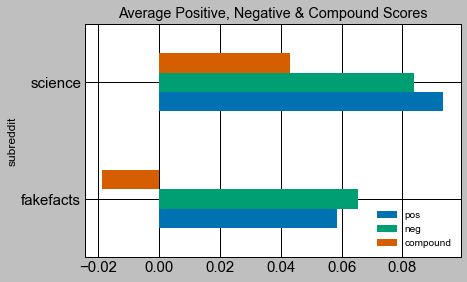

In [393]:
sentiment_df.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores');
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [ ]:
posts = pd.get_dummies(posts, columns=['subreddit'], drop_first=True)

In [ ]:
posts.to_csv('../data/subreddits_extra_features.csv', index = False)